# This is our best model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install tensorflow-addons
!pip install datasets
!pip install --upgrade accelerate

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import os
import ast
import spacy
import random
import itertools
import matplotlib.pyplot as plt
from typing import List, Tuple

import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoConfig, TFAutoModel

from transformers import DataCollatorForLanguageModeling
from transformers import DebertaTokenizer, DebertaForMaskedLM
from transformers import Trainer, TrainingArguments
from datasets import Dataset

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/TAR - projekt/TAR-dataset/train.csv')
train['annotation'] = train['annotation'].apply(ast.literal_eval) # Construct an object from a string
train['location'] = train['location'].apply(ast.literal_eval) # Construct an object from a string
print(f"train.shape: {train.shape}")
train

train.shape: (14300, 6)


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,[dad with recent heart attcak],[696 724]
1,00016_001,0,16,1,"[mom with ""thyroid disease]",[668 693]
2,00016_002,0,16,2,[chest pressure],[203 217]
3,00016_003,0,16,3,"[intermittent episodes, episode]","[70 91, 176 183]"
4,00016_004,0,16,4,[felt as if he were going to pass out],[222 258]
...,...,...,...,...,...,...
14295,95333_912,9,95333,912,[],[]
14296,95333_913,9,95333,913,[],[]
14297,95333_914,9,95333,914,[photobia],[274 282]
14298,95333_915,9,95333,915,[no sick contacts],[421 437]


In [ ]:
features = pd.read_csv('/content/drive/MyDrive/TAR - projekt/TAR-dataset/features.csv')
print(f"features.shape: {features.shape}")
features.head()

features.shape: (143, 3)


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [ ]:
patient_notes = pd.read_csv('/content/drive/MyDrive/TAR - projekt/TAR-dataset/patient_notes.csv')
print(f"patient_notes.shape: {patient_notes.shape}")
patient_notes.head()

patient_notes.shape: (42146, 3)


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [ ]:
train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
train['annotation_length'] = train['annotation'].apply(len)
print(f"train.shape: {train.shape}")

train.shape: (14300, 9)


In [ ]:
seed=42
train, test = train_test_split(train[['pn_history', 'pn_num', 'feature_text','annotation_length', 'location']], test_size=0.15, random_state=seed)

In [ ]:
test

,pn_history,pn_num,feature_text,annotation_length,location
4454,HPI 35 YO M IN OFFICE C/O BURNING EPIGASTRIC ...,30772,Awakens-at-night,0,[]
11329,"67-year-old female, has come to the physician'...",81385,Hallucinations-after-taking-Ambien,0,[]
1010,17 year old male presenting with heart poundin...,1809,heart-pounding-OR-heart-racing,2,"[33 47, 33 38;52 58]"
9329,17 YO MALE C/O CHEST PAIN SINCE YESTERDAY. P...,60922,Exercise-induced-asthma,1,[535 559]
3623,"Dolores Montgomery, a 44-year-old female, has ...",21372,Sexually-active,1,[399 414]
...,...,...,...,...,...
3559,Dolores Montgomery is a 44 year old previously...,21310,No-premenstrual-symptoms,0,[]
3323,3 year history of irregular menses. Pt has a c...,21114,Stress,0,[]
11098,Pt is 67 yr female presenting with trouble sle...,80706,Sleeping-medication-ineffective,1,[404 416;431 440]
8198,HPI: Patient is a 26F here for ED followup for...,55009,No-caffeine-use,0,[]


In [ ]:
"""
from transformers import DebertaTokenizer, DebertaForMaskedLM, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from datasets import load_dataset

from transformers import DebertaTokenizer, TFDebertaForMaskedLM
import tensorflow as tf

# Specify the name of your directory where the model is saved
model_dir = '/content/drive/MyDrive/TAR - projekt/savings/deberta-preTrain/checkpoint-40000'

# Specify the output directory for the converted model
output_dir = '/content/drive/MyDrive/TAR - projekt/savings/deberta-preTrain-converted'

# Load PyTorch model
pytorch_model = DebertaForMaskedLM.from_pretrained(model_dir)

# Convert PyTorch model to TensorFlow
tf_model = TFDebertaForMaskedLM.from_pretrained(model_dir, from_pt=True)

# Save the converted model
tf_model.save_pretrained(output_dir)
"""

"\nfrom transformers import DebertaTokenizer, TFDebertaForMaskedLM\nimport tensorflow as tf\n\n# Specify the name of your directory where the model is saved\nmodel_dir = '/content/drive/MyDrive/TAR - projekt/savings/deberta-preTrain/checkpoint-40000'\n\n# Specify the output directory for the converted model\noutput_dir = '/content/drive/MyDrive/TAR - projekt/savings/deberta-preTrain-converted'\n\n# Load PyTorch model\npytorch_model = DebertaForMaskedLM.from_pretrained(model_dir)\n\n# Convert PyTorch model to TensorFlow\ntf_model = TFDebertaForMaskedLM.from_pretrained(model_dir, from_pt=True)\n\n# Save the converted model\ntf_model.save_pretrained(output_dir)\n"

In [ ]:
MAX_LEN = 512
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

In [ ]:
# this functions are from:
# https://www.kaggle.com/yasufuminakama/nbme-deberta-base-baseline-train
# https://www.kaggle.com/code/ammarnassanalhajali/nbme-fine-tuning-deberta-tensorflow

def prepare_location(locations: str) -> List[Tuple[int]]:
    """
    This function returns list of tuples of locations
    """
    location_tuple_list = []
    for location in locations:
        for loc in [s.split() for s in location.split(';')]:
            start, end = int(loc[0]), int(loc[1])
            location_tuple_list.append((start, end))
    
    return location_tuple_list

def prepare_input(pn_history: str, feature_text: str):
    """
    This function tokenizes pn_history and feature text and
    returns numpy array of input_ids and attention_masks
    """
    tokens = tokenizer(
        pn_history,
        feature_text,
        max_length=MAX_LEN,
        padding="max_length",
        add_special_tokens=True,
    )
    
    input_ids = tokens['input_ids']
    attention_mask = tokens["attention_mask"]
    return np.array(input_ids), np.array(attention_mask)

def prepare_labels(pn_history, annotation_length, location_list):
    """
    This function creates labels with are vectors of zeros (no entity)
    and ones (entity)
    """
    tokenized = tokenizer(
        pn_history,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding="max_length",
        return_offsets_mapping=True
    )
    offset_mapping = tokenized["offset_mapping"]
    #print(offset_mapping)
    #print(f'Len of offset: {len(offset_mapping)}')
    label = np.zeros(len(offset_mapping))
    if annotation_length != 0:
        locations = prepare_location(location_list)
        #print(locations)
        for location in locations:
            start_idx, end_idx = -1, -1
            start, end = location
            for idx in range(len(offset_mapping)):
                if (start_idx == -1) & (start < offset_mapping[idx][0]):
                    start_idx = idx - 1
                if (end_idx == -1) & (end <= offset_mapping[idx][1]):
                    end_idx = idx + 1
            if start_idx == -1:
                start_idx = end_idx
            if (start_idx != -1) & (end_idx != -1):
                label[start_idx:end_idx] = 1
            
    return np.array(label)

In [ ]:
def create_data(dataframe: pd.DataFrame,train=True):
    pn_history = dataframe["pn_history"].values # stavi sve notes u array
    feature_text = dataframe["feature_text"].values # svi featuri u array
    if train:
        annotation_length = dataframe['annotation_length'].values # ak treniram uzmi i duzinu anotacije
        location = dataframe['location'].values # uzmi anotacije
    input_ids = []
    attention_mask = []
    labels = []

    for i in range(len(dataframe)):
        inputs, masks = prepare_input(pn_history[i], feature_text[i])
        input_ids.append(inputs)
        attention_mask.append(masks)
        if train:
            lbls = prepare_labels(pn_history[i], annotation_length[i], location[i])
            labels.append(lbls)
    return {"input_ids":input_ids,"attention_mask":attention_mask}, labels

In [ ]:
train, valid = train_test_split(train, test_size=0.1, random_state=seed)
    
train_data, train_labels = create_data(train,train=True)
val_data, val_labels = create_data(valid,train=True)

In [ ]:
train_data_X =(np.asarray(train_data['input_ids']),np.asarray(train_data['attention_mask']))          
train_data_Y =np.asarray(train_labels).ravel()

valid_data = ((np.asarray(val_data['input_ids']),
              np.asarray(val_data['attention_mask']),
             ),np.asarray(val_labels).ravel())

In [ ]:
save_path = '/content/drive/MyDrive/TAR - projekt/savings'

model_save = tf.keras.callbacks.ModelCheckpoint(
    f'{save_path}/deBERTA_final_BEST/tuned_additional.h5', 
    save_best_only = True, 
    save_weights_only = True,
    monitor = 'val_f1', 
    mode = 'max', verbose = 1
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1', 
    min_delta=1e-5, 
    patience=5, 
    verbose=1,
    mode='max', 
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_f1', 
    factor=0.5, 
    patience=2, 
    mode='max', 
    min_delta=0.001,
    verbose = 1
)

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.f1 = tfa.metrics.F1Score(num_classes=2, average='micro', threshold=0.50)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, (-1,MAX_LEN))
        y_pred = tf.reshape(y_pred, (-1,MAX_LEN))
        self.f1.update_state(y_true, y_pred)
        
    def reset_state(self):
        self.f1.reset_state()
    
    def result(self):
        return self.f1.result()
    
metrics = [
    F1Score()
]

# ---------- Training ----------
BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 2e-5
CLIP_NORM = 1000

In [ ]:
config = AutoConfig.from_pretrained("/content/drive/MyDrive/TAR - projekt/savings/deberta-preTrain-converted", output_hidden_states=True)

In [ ]:
def create_model() -> tf.keras.Model:
    input_tokens = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32) # layer za 1d input duljine 512
    attention_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32) # layer za 1d mask

    backbone = TFAutoModel.from_pretrained("/content/drive/MyDrive/TAR - projekt/savings/deberta-preTrain-converted", config=config) 

    out = backbone(input_tokens, attention_mask=attention_mask)[0]
    out = tf.keras.layers.Dropout(0.2)(out)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(out)

    return tf.keras.Model(inputs=[input_tokens, attention_mask], outputs=out)

model = create_model()
model.summary()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, clipnorm=CLIP_NORM)
loss = tf.keras.losses.BinaryCrossentropy(reduction="none")
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

Some layers from the model checkpoint at /content/drive/MyDrive/TAR - projekt/savings/deberta-preTrain-converted were not used when initializing TFDebertaModel: ['cls']
- This IS expected if you are initializing TFDebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDebertaModel were initialized from the model checkpoint at /content/drive/MyDrive/TAR - projekt/savings/deberta-preTrain-converted.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_deberta_model (TFDebertaMod  TFBaseModelOutput(l  138601728  ['input_1[0][0]',                
 el)                            ast_hidden_state=(N               'input_2[0][0]']                
                                one, 512, 768),                                                   
                                 hidden_states=((No                                           

In [ ]:
train_data_X =(np.asarray(train_data['input_ids']),np.asarray(train_data['attention_mask']))          
train_data_Y =np.asarray(train_labels)

valid_data = ((np.asarray(val_data['input_ids']),
              np.asarray(val_data['attention_mask']),
             ),np.asarray(val_labels))

In [ ]:
history=model.fit(
            train_data_X,
            train_data_Y, 
            epochs = EPOCHS,
            shuffle=True,
            batch_size = BATCH_SIZE,
            validation_data= valid_data,
            callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/10


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


684/684 [==============================] - ETA: 0s - loss: 0.0126 - f1: 0.6618
Epoch 1: val_f1 improved from -inf to 0.84804, saving model to /content/drive/MyDrive/TAR - projekt/savings/deBERTA_final/tuned.h5
684/684 [==============================] - 960s 1s/step - loss: 0.0126 - f1: 0.6618 - val_loss: 0.0054 - val_f1: 0.8480 - lr: 2.0000e-05
Epoch 2/10
684/684 [==============================] - ETA: 0s - loss: 0.0048 - f1: 0.8523
Epoch 2: val_f1 improved from 0.84804 to 0.86860, saving model to /content/drive/MyDrive/TAR - projekt/savings/deBERTA_final/tuned.h5
684/684 [==============================] - 836s 1s/step - loss: 0.0048 - f1: 0.8523 - val_loss: 0.0048 - val_f1: 0.8686 - lr: 2.0000e-05
Epoch 3/10
684/684 [==============================] - ETA: 0s - loss: 0.0037 - f1: 0.8864
Epoch 3: val_f1 improved from 0.86860 to 0.87524, saving model to /content/drive/MyDrive/TAR - projekt/savings/deBERTA_final/tuned.h5
684/684 [==============================] - 835s 1s/step - loss: 0.00

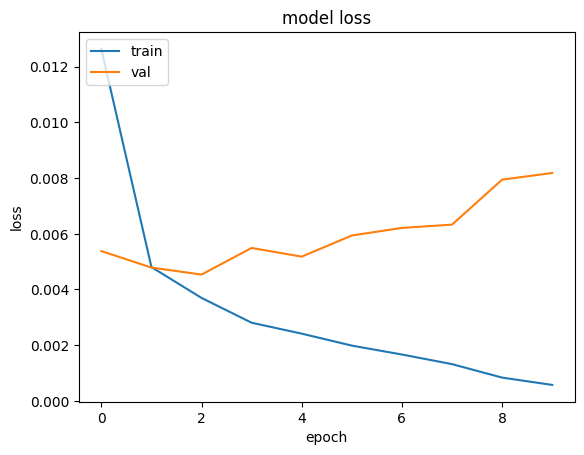

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

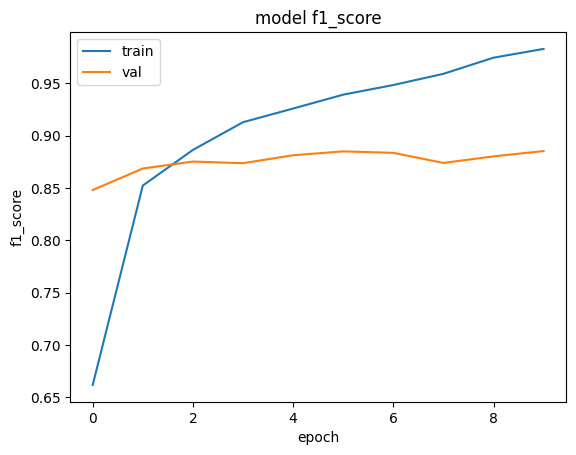

In [ ]:
# Summarizes history for accuracy
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()